In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import show

from sklearn import preprocessing as pp
from sklearn.model_selection import KFold , cross_val_score
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score

%matplotlib inline
sns.set_context('notebook')
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500) # to see all columns

In [2]:

data_agr = pd.read_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')
data_agr.head()

,playerShort,player,club,leagueCountry,birthday,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,rater1,rater2,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,color_rating,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr
0,0,392,34,0,360,182.0,71.0,1,654,247,179,228,9,19,0,0,0.25,0.00,166,37,0.346459,0.003297,0.494575,0.013752,1,0.328409,0.367721,0.333195,0.400637
1,1,393,91,2,176,183.0,73.0,0,336,141,73,122,62,42,0,1,0.00,0.25,99,25,0.348818,0.003297,0.449220,0.013752,2,0.329945,0.441615,0.341438,0.380811
2,2,394,83,0,719,165.0,63.0,11,412,200,97,115,31,11,0,0,0.25,0.25,101,28,0.345893,0.003297,0.491482,0.013752,2,0.328230,0.365628,0.332389,0.399459
3,3,395,6,0,1199,178.0,76.0,3,260,150,42,68,39,31,0,1,0.00,0.00,104,37,0.346821,0.003297,0.514693,0.013752,1,0.327775,0.412859,0.336638,0.433294
4,4,396,51,1,758,180.0,73.0,1,124,41,40,43,1,8,4,2,0.25,0.25,37,11,0.331600,0.000151,0.335587,0.000586,2,0.338847,0.379497,0.331882,0.328895


In [3]:
data_agr.shape


(1585, 29)

<font color='red'> drop rater1 and rater2 </font>

We drop the features that are unique to the players

In [4]:
data_agr = pd.read_csv('CrowdstormingDataJuly1st_aggregated_encoded.csv')
data_agr = data_agr.drop(['playerShort', 'player', 'birthday'], axis=1)
data_agr = data_agr.drop(['rater1', 'rater2'], axis=1)
data_train = data_agr.drop(['color_rating'], axis=1)
colors = data_agr['color_rating']
col = data_train.columns
data_train = pd.DataFrame(pp.normalize(data_train))
data_train.columns = col
data_train.head()


,club,leagueCountry,height,weight,position,games,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,refCount,refCountryCount,meanIAT,seIAT,meanExp,seExp,meanIAT_nIAT,meanExp_nExp,meanIAT_GameNbr,meanExp_GameNbr
0,0.042452,0.000000,0.227245,0.088650,0.001249,0.816582,0.308403,0.223499,0.284680,0.011237,0.023723,0.000000,0.000000,0.207267,0.046198,0.000433,4.116384e-06,0.000618,0.000017,0.000410,0.000459,0.000416,0.000500
1,0.195742,0.004302,0.393636,0.157024,0.000000,0.722741,0.303293,0.157024,0.262424,0.133363,0.090343,0.000000,0.002151,0.212951,0.053775,0.000750,7.091489e-06,0.000966,0.000030,0.000710,0.000950,0.000734,0.000819
2,0.156118,0.000000,0.310356,0.118499,0.020690,0.774948,0.376189,0.182451,0.216308,0.058309,0.020690,0.000000,0.000000,0.189975,0.052666,0.000651,6.201110e-06,0.000924,0.000026,0.000617,0.000688,0.000625,0.000751
3,0.015561,0.000000,0.461658,0.197112,0.007781,0.674331,0.389037,0.108930,0.176364,0.101150,0.080401,0.000000,0.002594,0.269733,0.095963,0.000900,8.550547e-06,0.001335,0.000036,0.000850,0.001071,0.000873,0.001124
4,0.204141,0.004003,0.720498,0.292202,0.004003,0.496343,0.164113,0.160111,0.172119,0.004003,0.032022,0.016011,0.008006,0.148102,0.044030,0.001327,6.039560e-07,0.001343,0.000002,0.001356,0.001519,0.001328,0.001316


## KMeans

In [5]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [6]:
np.random.seed(1)
nbr_class = 2

since there are 5 variation of skin colors, we categorize the color_ratings as follows
- 1,2: light
- 3: neutral (fits both descriptions)
- 4,5: dark

In [9]:
def wrong_pred(ratings, labels):
#     ratings = data.color_rating
    ratings = ratings.apply(lambda x: mapping(x))  
    dif = np.abs(ratings - labels)
    return (min(len(dif[dif==1]), len(dif[dif==0]))/len(labels))

def mapping(x):
    if (x < 3):
        return 0
    if (x == 3):
        return 0.5
    return 1
def fit_data(data):
    kmeans = KMeans(init='k-means++', n_clusters=nbr_class, n_init=1)
    kmeans.fit(data_temp)
    silhouette = metrics.silhouette_score(data_temp, kmeans.labels_, metric='euclidean')
    skin = wrong_pred(colors, kmeans.labels_)
    return silhouette, skin
        

In [12]:
# iteratively drop feature that has the lowest silhouette score

silhouettes_scores = []
skin_scores = []
number_features = data_train.columns
d = data_train
globalbest = -1
while (len(d.columns) > 1):
    current_best = -1
    for feature in d:
        data_temp = d.drop([feature], axis=1)
        silhouette, skin = fit_data(data_temp)
        if (silhouette > current_best):
            current_best = silhouette
            current_skin = skin
            worst_feature = feature
        if(silhouette > globalbest):
            globalbest = silhouette
#             print('new best ' + str(score))
    silhouettes_scores.append(current_best)
    skin_scores.append(current_skin)
    print('worst feature is ' + worst_feature + ' without it silhouette is ' + str(current_best))
    print('dark_light prediction made ' + str(current_skin) + ' wrong prediction' )
    print('')
    d = d.drop([worst_feature], axis=1)
print(d.columns)
print(silhouettes_scores)
print(current_skin)
    

worst feature is club without it silhouette is 0.460877668034
dark_light prediction made 0.35646687697160884 wrong prediction

worst feature is goals without it silhouette is 0.488927063199
dark_light prediction made 0.3438485804416404 wrong prediction

worst feature is refCount without it silhouette is 0.502921353122
dark_light prediction made 0.35457413249211356 wrong prediction

worst feature is victories without it silhouette is 0.519759311069
dark_light prediction made 0.3482649842271293 wrong prediction

worst feature is height without it silhouette is 0.540763294386
dark_light prediction made 0.2908517350157729 wrong prediction

worst feature is yellowCards without it silhouette is 0.55846944448
dark_light prediction made 0.3053627760252366 wrong prediction

worst feature is defeats without it silhouette is 0.585255002338
dark_light prediction made 0.3041009463722397 wrong prediction

worst feature is weight without it silhouette is 0.609678248278
dark_light prediction made 0.29

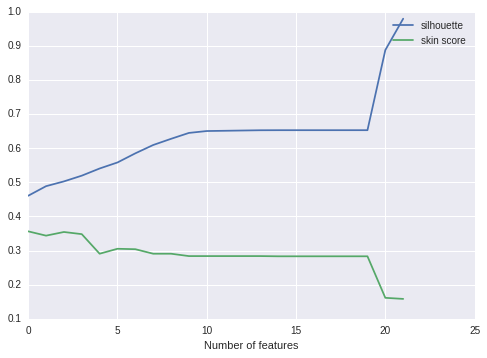

In [15]:
plt.plot( silhouettes_scores, label='silhouette')
plt.plot( skin_scores, label = 'skin score')
plt.xlabel('Number of features')
plt.legend()